In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

def setup_logging(epoch_key, date_format='%d-%b-%y %H:%M:%S', format='%(asctime)s %(message)s'):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)

sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
setup_logging(epoch_key)

In [5]:
from dask.distributed import Client

# for virga
client = Client(n_workers=28, threads_per_worker=2, processes=True)

client

/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42359 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:37187 Dashboard: http://127.0.0.1:42359/status,Cluster Workers: 28 Cores: 56 Memory: 1.62 TB


In [6]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

20-May-21 15:05:33 Loading position info...
20-May-21 15:06:12 Loading multiunit...
20-May-21 15:06:39 Loading spikes...
20-May-21 15:08:09 Finding ripple times...


In [7]:
continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 16.0])}, 
}

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING, PROCESSED_DATA_DIR

from sklearn.model_selection import KFold
import os

state_names = ['Continuous', 'Fragmented']
cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = ClusterlessClassifier(**classifier_parameters)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        track_graph=data["track_graph"],
        edge_order=WTRACK_EDGE_ORDER,
        edge_spacing=WTRACK_EDGE_SPACING,
    )
    classifier.save_model(
        os.path.join(PROCESSED_DATA_DIR,
            f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_"
            f"clusterless_increase_smoothing_fold{fold_ind}_model.pkl")
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["multiunits"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
            state_names=state_names
        )
    )
    
# concatenate results 
results = xr.concat(
    results, dim="time"
)

# save the results as .nc format. ncread matlab can read these
results.to_netcdf(
    os.path.join(PROCESSED_DATA_DIR,
   f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_clusterless_increase_smoothing_results.nc")
)
logging.info('Done...\n\n')

20-May-21 15:09:00 Fitting Fold #1...
20-May-21 15:09:01 Fitting initial conditions...
20-May-21 15:09:02 Fitting state transition...
20-May-21 15:09:02 Fitting multiunits...
20-May-21 15:09:08 Predicting posterior...


In [ ]:
client.close()

In [ ]:
from src.visualization import plot_classifier_time_slice

n_time = results.time.shape[0]
time_slice_step = 15_000
time_range = zip(range(0, n_time, time_slice_step),
                 range(time_slice_step, n_time + time_slice_step,
                       time_slice_step))

for start_ind, end_ind in time_range:
    plot_classifier_time_slice(
        results.time[slice(start_ind, end_ind)],
        classifier,
        results,
        data,
        posterior_type="acausal_posterior",
        figsize=(30, 15),
    )

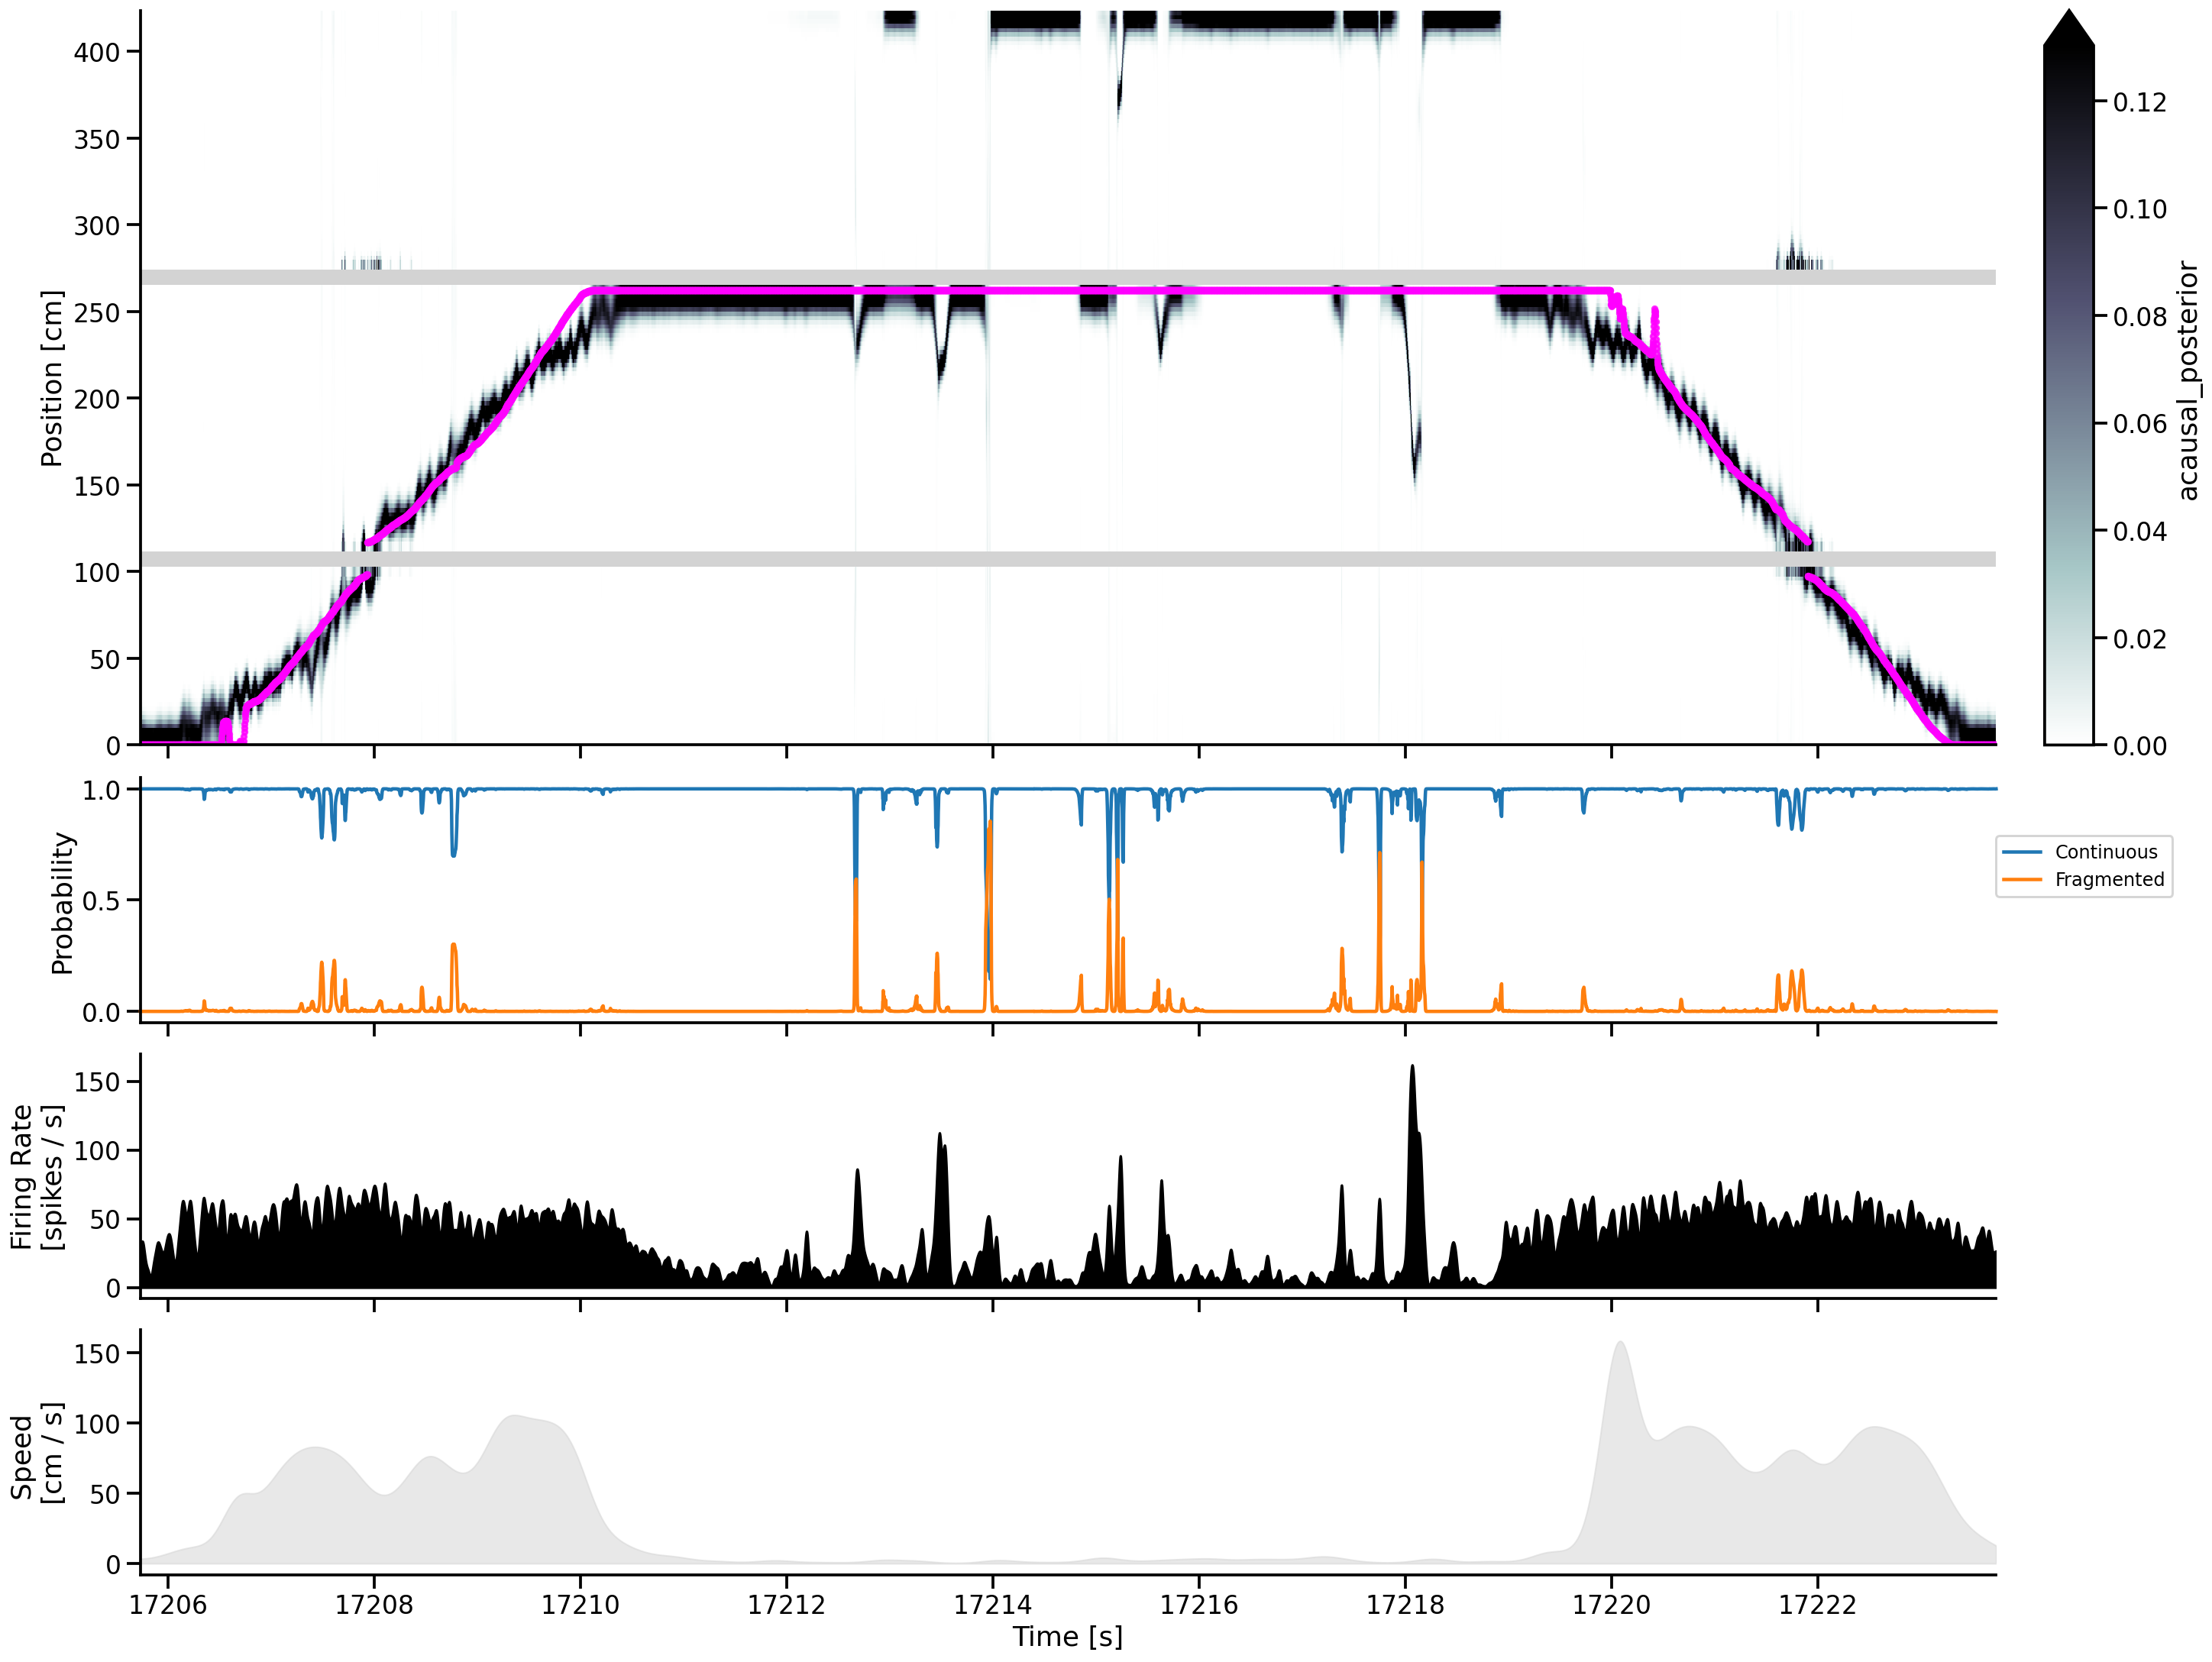

In [14]:
plot_classifier_time_slice(
    results.time[slice(422_000, 431_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=True,
)

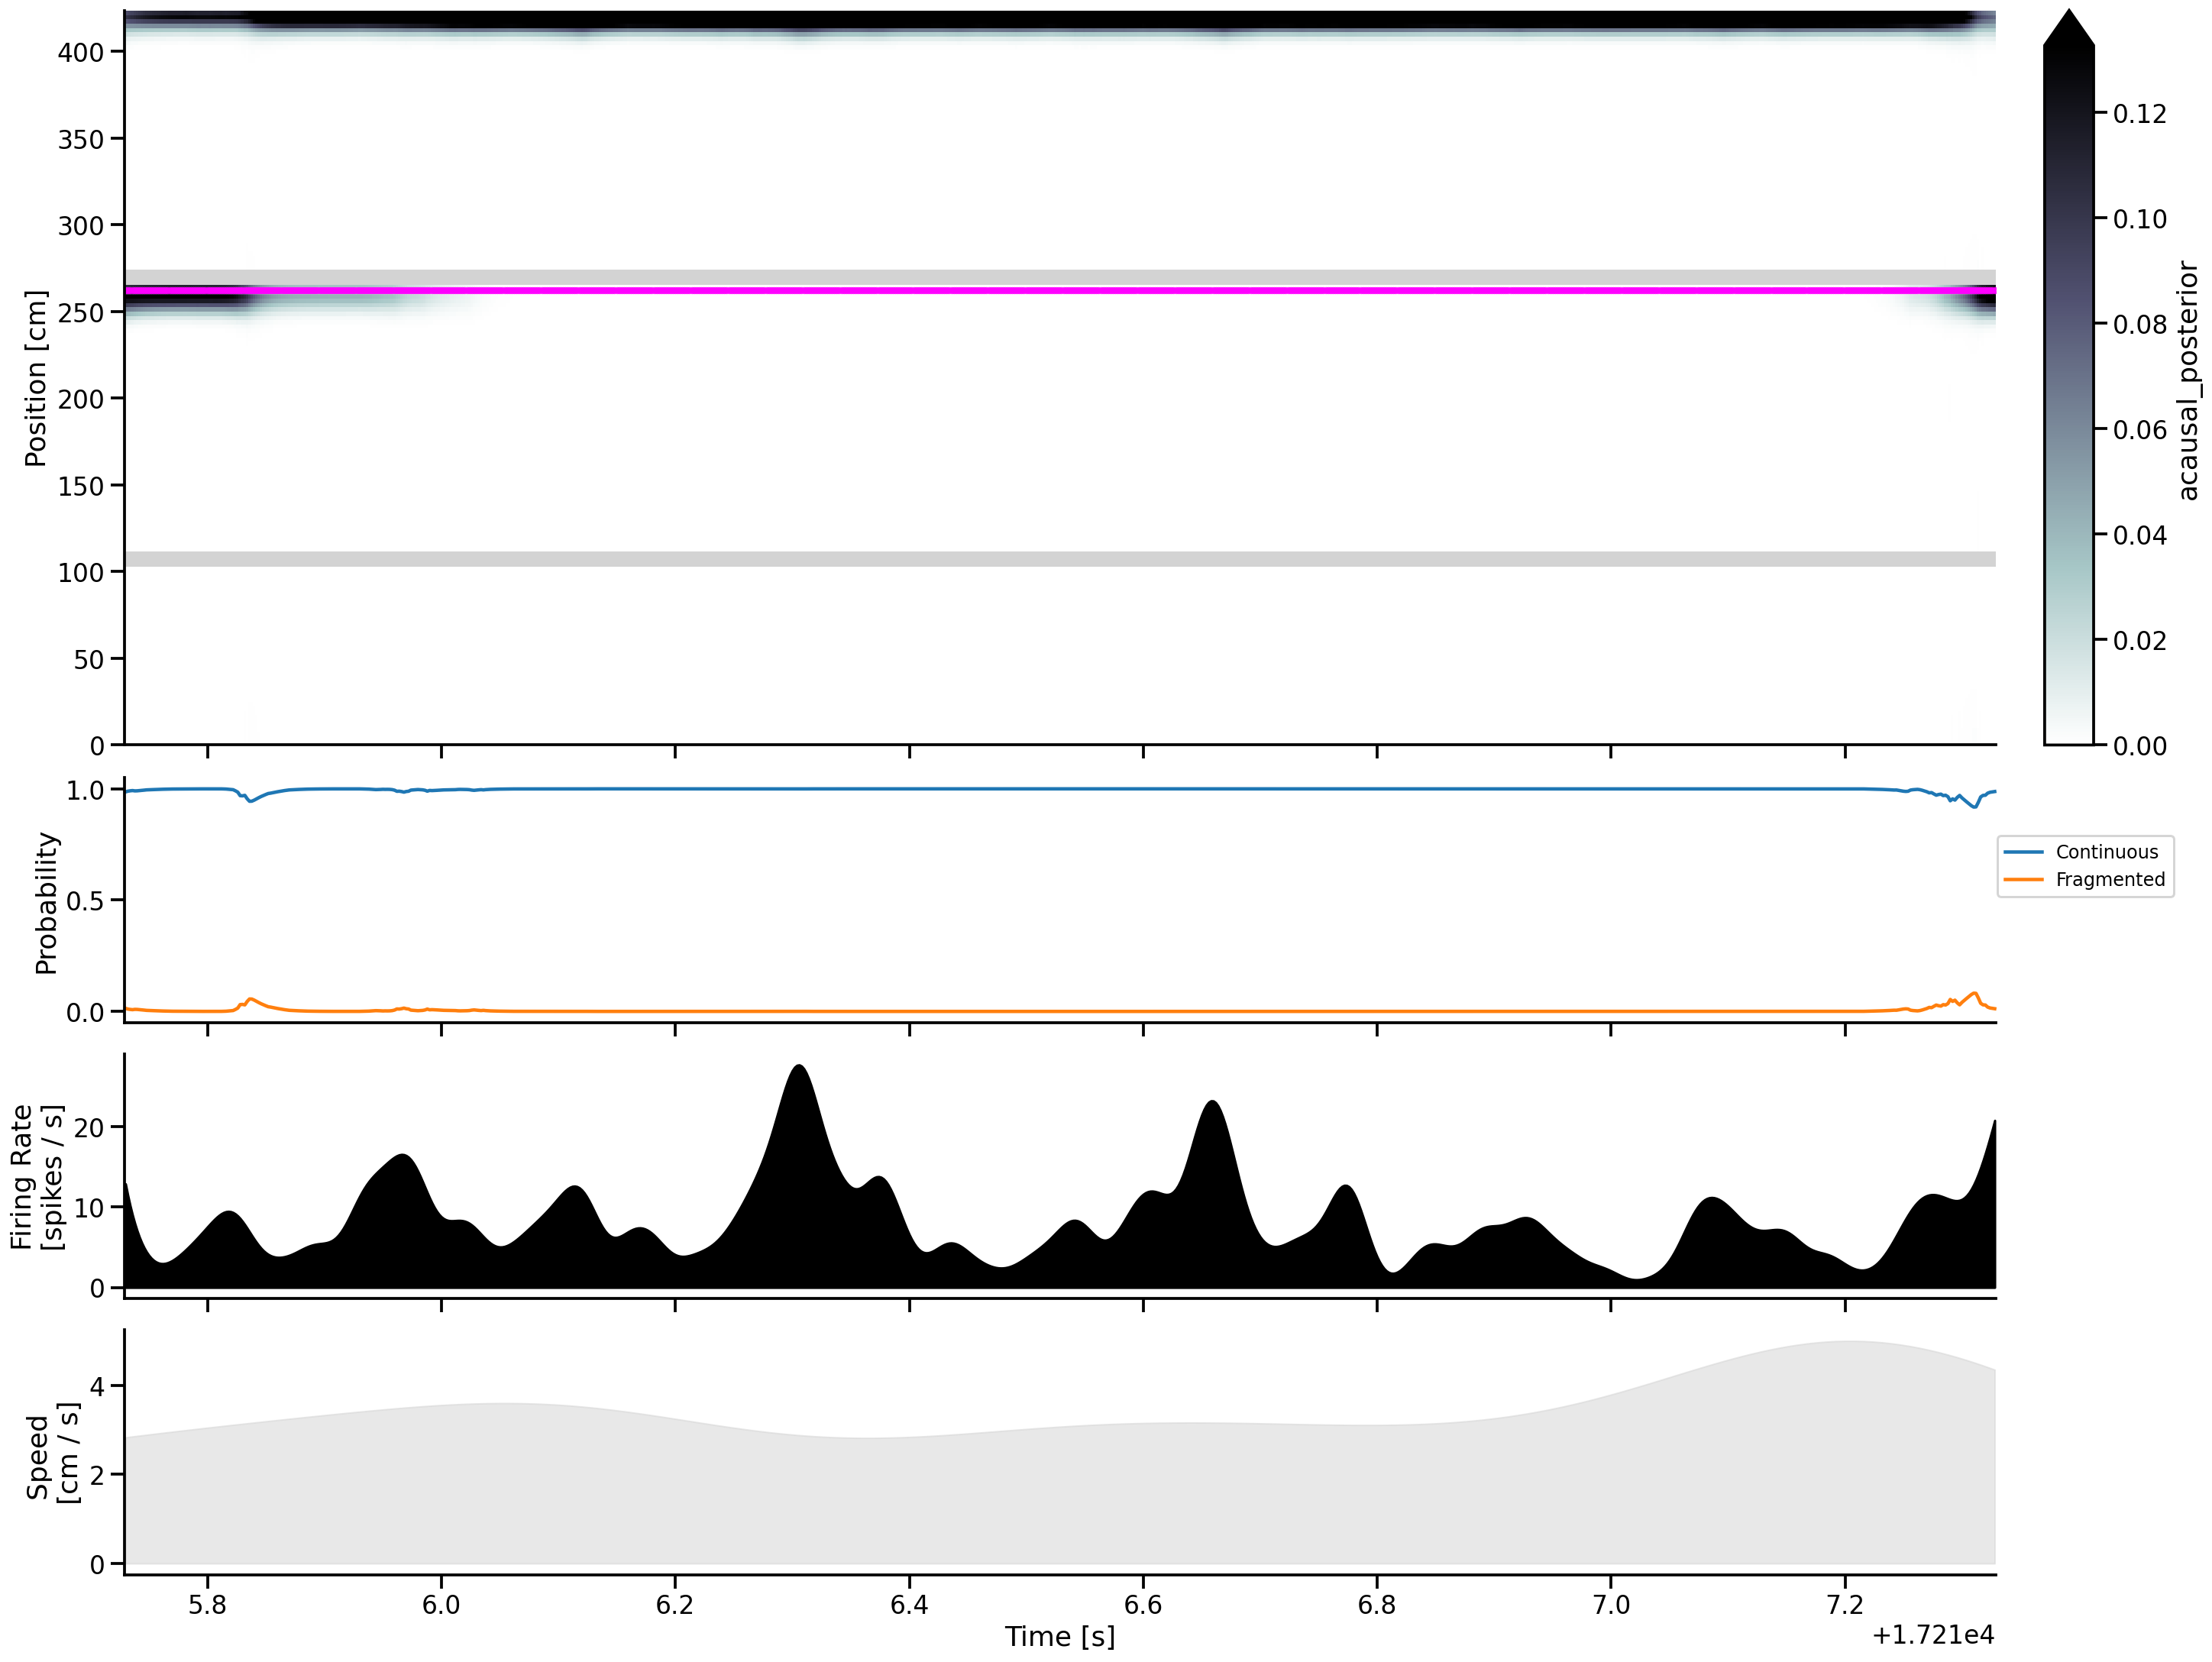

In [15]:
plot_classifier_time_slice(
    results.time[slice(427_000, 427_800)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=True,
)

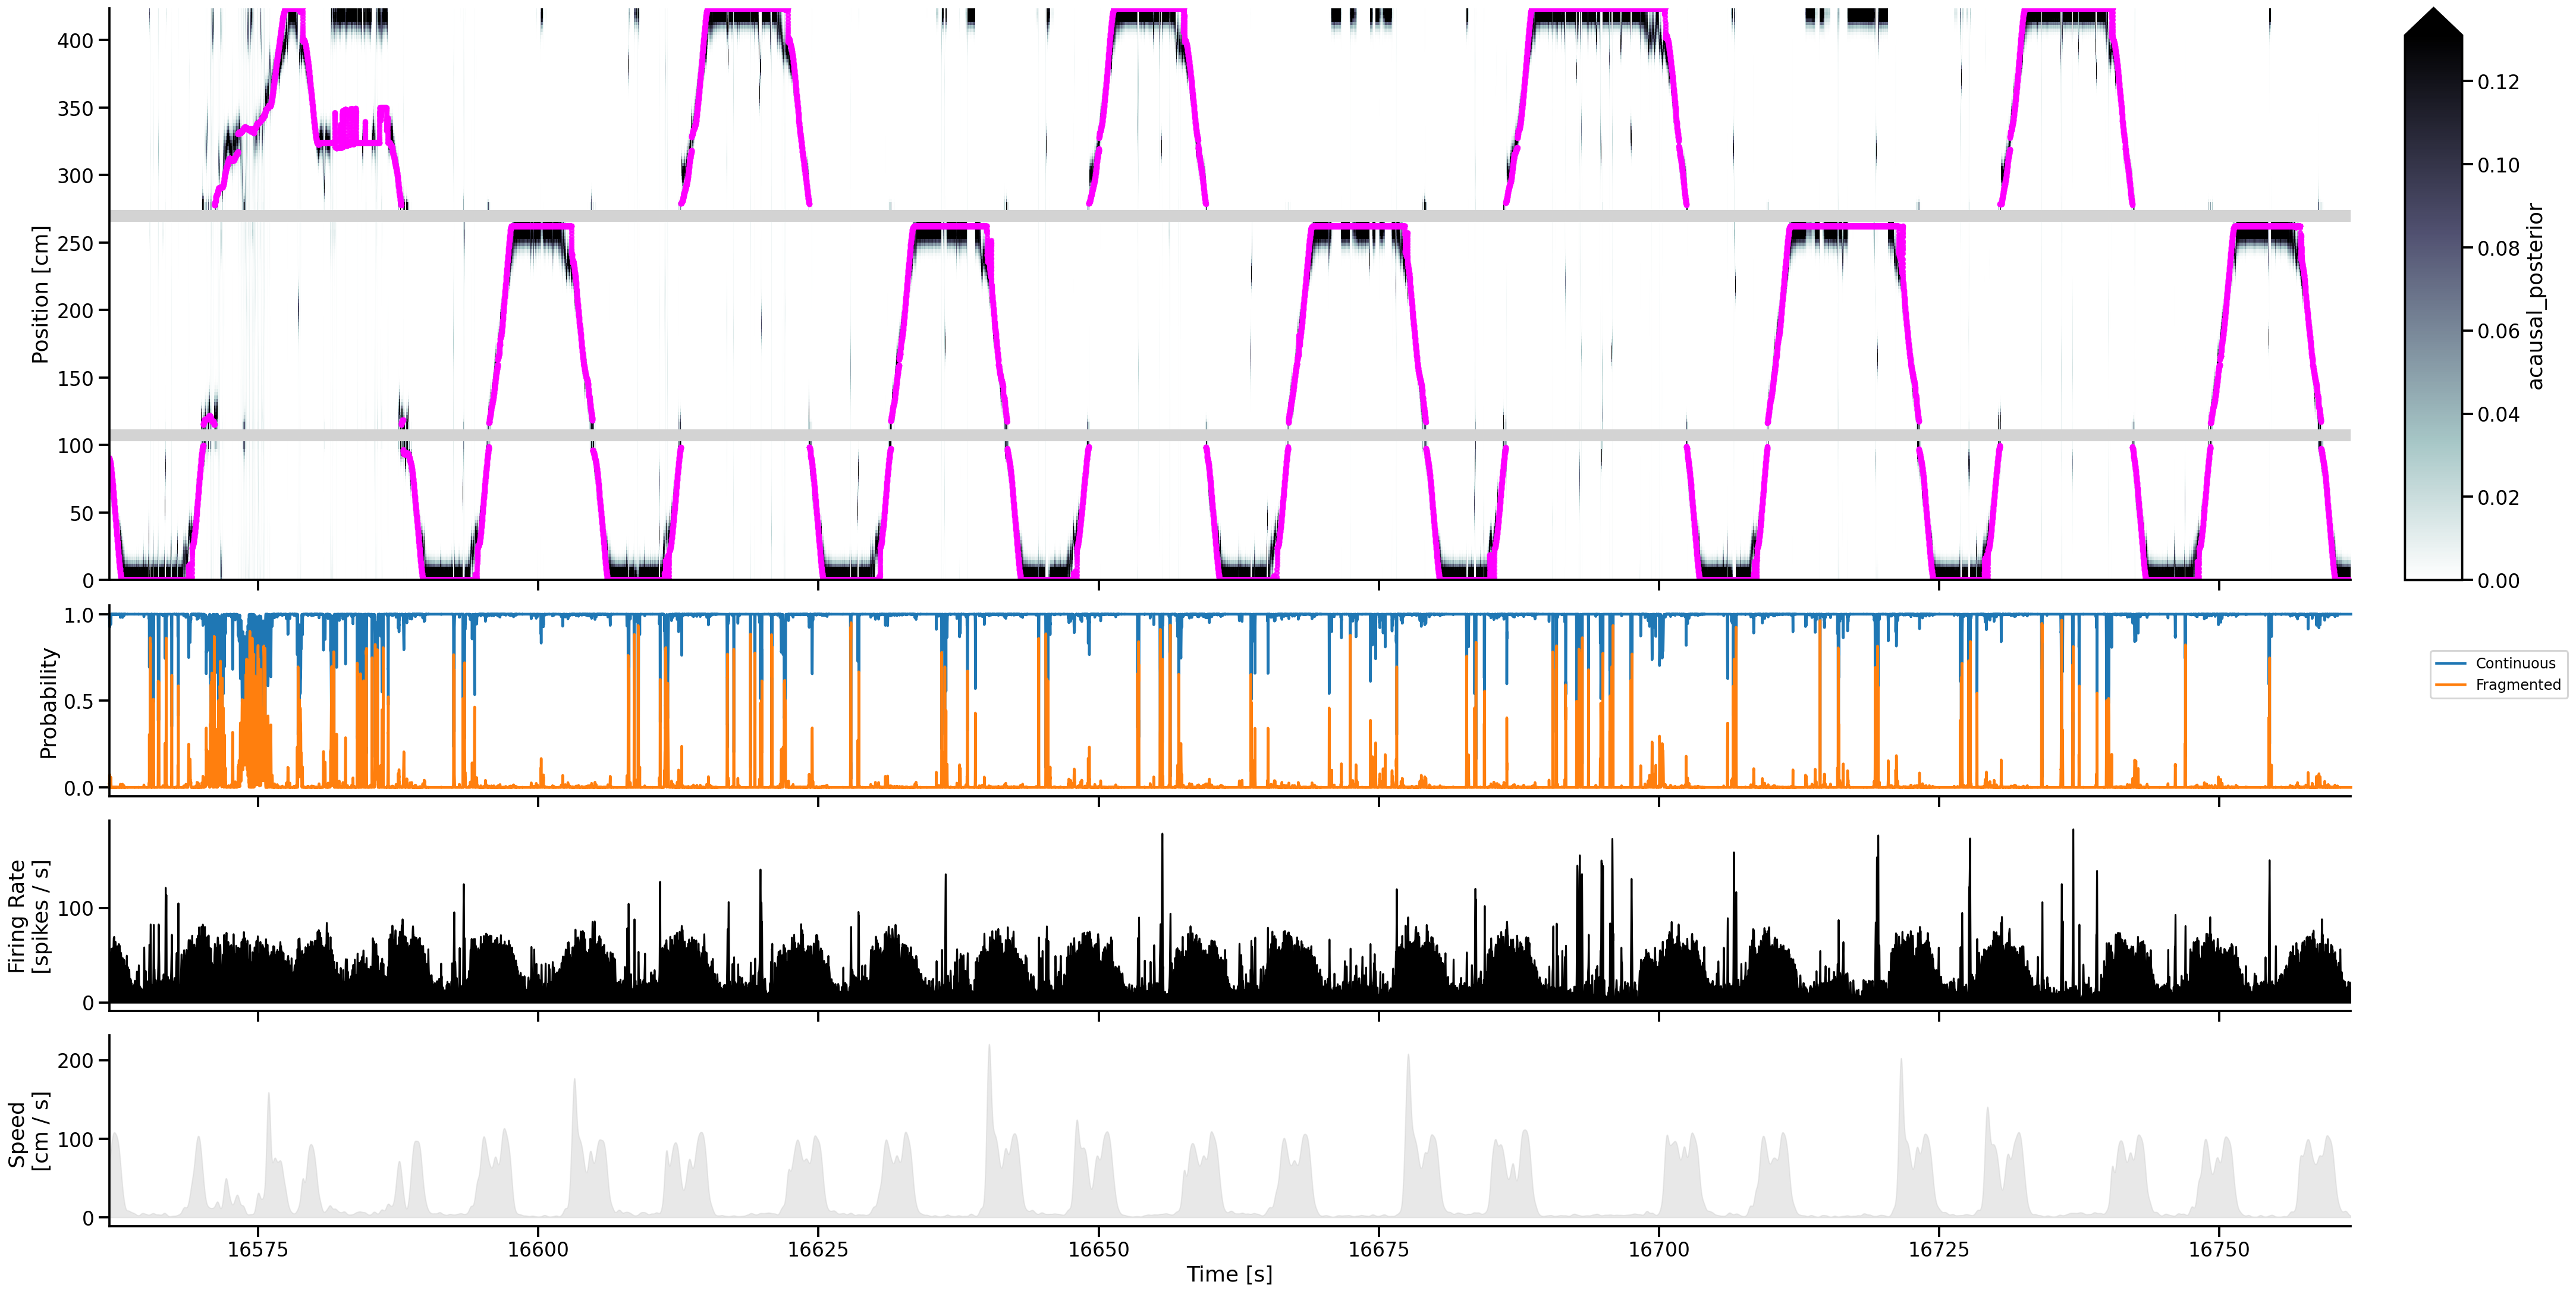

In [16]:
plot_classifier_time_slice(
    results.time[slice(100_000, 200_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
    legend=True,
)

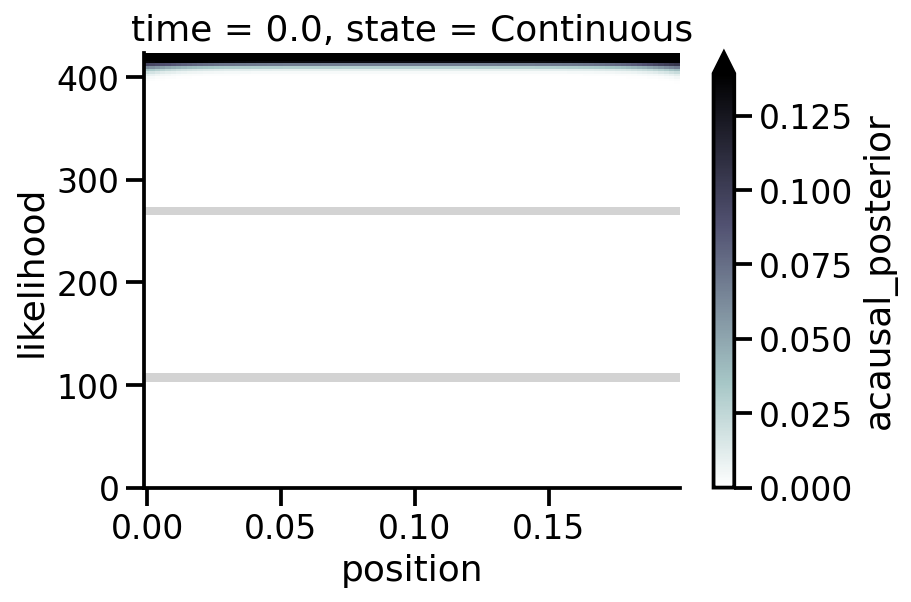

In [26]:
from src.parameters import SAMPLING_FREQUENCY
import copy

n_features, n_tetrodes = data['multiunits'].shape[1:]
n_time = 100

no_spike_results = (
    classifier.predict(
        np.full((n_time, n_features, n_tetrodes), np.nan),
        time=np.arange(n_time) / SAMPLING_FREQUENCY,
        state_names=state_names
    )
)

cmap = copy.copy(plt.get_cmap('bone_r'))
cmap.set_bad(color="lightgrey", alpha=1.0)

(no_spike_results
 .acausal_posterior
 .sum('state')
 .where(classifier.is_track_interior_)
 .plot(x='time', y='position', robust=True, vmin=0.0, cmap=cmap))
sns.despine()

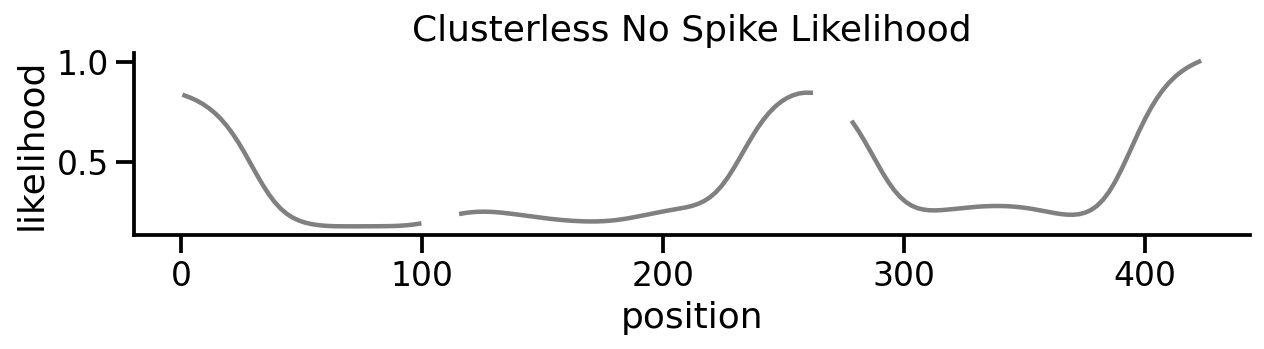

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5 / 3))
no_spike_results.likelihood.isel(time=0, state=0).plot(x='position', ax=ax, color='grey')
plt.title('Clusterless No Spike Likelihood')
sns.despine()